
<div style="background-color:white; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><strong>Giant Hogweed Detection</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse;">
            <tr>
                <th style="border: 0;">Names</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Vince Ammerlaan</td>
                <td style="border: 0;">Vince16270</td>
            </tr>
            <tr>
                <td style="border: 0;">Tommi Lander</td>
                <td style="border: 0;">tommi7</td>
            </tr>
            <tr>
                <td style="border: 0;">Nima Ghafar</td>
                <td style="border: 0;">NimaGhafar</td>
            </tr>
        </table>
    </p>
</div>

<div style="display: flex; justify-content: center; align-items: center; margin-top:20px;">
    <img src="https://lizzieharper.co.uk/wp-content/uploads/2023/03/Giant-Hogweed-Heracleum-mantegazzianum-lo-371x525.jpg" alt="genres" style="max-width: 100%; max-height: 100%;">
</div>

- Client: Sieuwe Elferink
- Instructors: Bob Tuinman, Pascal van den Bosch
- Date: 21-6-2024 

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Table of contents </strong></h2>
</div>
<ul style="padding: 0; list-style: none;">
    <li style="text-align: center;"><a href="#1.0">Chapter 1: The Project</a></li>
    <li style="text-align: center;"><a href="#1.0">Chapter 2: Loading Data</a></li>
    <li style="text-align: center;"><a href="#2.0">Chapter 3: Exploratory Data Analysis</a></li>
    <li style="text-align: center;"><a href="#3.0">Chapter 4: Different Models</a></li>
    <li style="text-align: center;"><a href="#6.0">Chapter 5: Comparing the Models</a></li>
    <li style="text-align: center;"><a href="#5.0">Chapter 6: Using own data on the best model </a></li>
    <li style="text-align: center;"><a href="#7.0">Chapter 7: API to call the best model</a></li>
    <li style="text-align: center;"><a href="#7.0">Chapter 8: Results and Conclusions</a></li>
    <li style="text-align: center;"><a href="#8.0">Chapter 9: Sources</a></li>
</ul>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 1: The Project </strong></h2>

</ul>

The giant hogweed is a plant that causes a lot of nuisance and if you touch it, you can get severe burns. This is due to the sap of the plant. The common hogweed, on the other hand, does not cause such problems and is much less dangerous. You can distinguish the giant hogweed from the common hogweed by its coarse, large leaves and rapid growth compared to the more modest, finer leaves of the common hogweed.

Our project faces several complications. One of the biggest challenges is the lack of available drone data, which is essential for training the model to detect the hogweed. Since we do not have this data available, we have to make our own drone recordings and then create masks for image recognition. This process is very time-consuming.

In addition, there are other challenges associated with obtaining this data. Flying drones requires specific permits and safety measures, especially in areas where the giant hogweed grows, which are often difficult to access.

Despite these challenges, we are determined to find solutions and make our project a success.

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 2: Loading data </strong></h2>

</ul>

**Packages**

In [1]:
import os
import requests
import numpy as np
from PIL import Image
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Model
from IPython.display import display, Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50, Xception, MobileNetV2, DenseNet121
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Activation, MaxPooling2D, concatenate, UpSampling2D, Layer
from tensorflow.keras.layers import concatenate, UpSampling2D, Conv2DTranspose, BatchNormalization, Add, Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D, DepthwiseConv2D, Lambda

**Own defined functions**

In [2]:
def split_and_save_images(image_dir, output_dir, patch_size=256):
    """
    Split images into patches of size patch_size x patch_size and save them in output_dir.

    Args:
    image_dir (str): Path to the directory containing the images.
    output_dir (str): Path to the directory where the patches will be saved.
    patch_size (int): Size of the patches.
    """
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_names = os.listdir(image_dir)

    for file_name in file_names:
        image_path = os.path.join(image_dir, file_name)
        if os.path.isfile(image_path):
            image = Image.open(image_path)
            width, height = image.size

            num_patches_x = width // patch_size
            num_patches_y = height // patch_size

            for i in range(num_patches_x):
                for j in range(num_patches_y):
                    left = i * patch_size
                    upper = j * patch_size
                    right = (i + 1) * patch_size
                    lower = (j + 1) * patch_size
                    
                    patch = image.crop((left, upper, right, lower))
                    patch_name = f"{file_name.split('.')[0]}_patch_{i}_{j}.jpg"
                    patch.save(os.path.join(output_dir, patch_name))

In [3]:
def preprocess_mask(mask):
    """
    Preprocesses the input mask by scaling its pixel values to the range [0, 1].

    Args:
        mask (numpy.ndarray): Input mask image.

    Returns:
        numpy.ndarray: Preprocessed mask image with pixel values scaled to the range [0, 1].
    """
    mask = mask / 255.0
    return mask

In [4]:
def display_images(display_list, title_list):
    """
    Displays a list of images along with their corresponding titles in a single figure.

    Args:
        display_list (list): List of images to be displayed.
        title_list (list): List of titles for each image.

    Returns:
        None
    """
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title_list[i])
        if len(display_list[i].shape) == 2:
            display_image = tf.expand_dims(display_list[i], axis=-1)
        else:
            display_image = display_list[i]
        plt.imshow(tf.keras.utils.array_to_img(display_image))
        plt.axis('off')
    plt.show()

In [5]:
def augment_image(image, mask):
    """
    Augments an input image and its corresponding mask using horizontal and vertical flips
    while ensuring both undergo the same transformations.

    Args:
        image (numpy.ndarray): Input image.
        mask (numpy.ndarray): Corresponding mask image.

    Returns:
        numpy.ndarray: Augmented image.
        numpy.ndarray: Augmented mask.
    """
    data_gen_args = dict(
        horizontal_flip=True,
        vertical_flip=True
    )
    
    image_data_gen = ImageDataGenerator(**data_gen_args)
    mask_data_gen = ImageDataGenerator(**data_gen_args)

    seed = np.random.randint(0, 10000)
    
    image_data_gen.fit(np.expand_dims(image, 0), augment=True, seed=seed)
    mask_data_gen.fit(np.expand_dims(mask, 0), augment=True, seed=seed)

    aug_image = next(image_data_gen.flow(np.expand_dims(image, 0), batch_size=1, seed=seed))[0]
    aug_mask = next(mask_data_gen.flow(np.expand_dims(mask, 0), batch_size=1, seed=seed))[0]

    return aug_image, aug_mask

In [6]:
def parse_image(img_path, mask_path):
    """
    Parses an image and its corresponding mask from the given file paths.

    Args:
        img_path (str): Path to the image file.
        mask_path (str): Path to the mask file.

    Returns:
        numpy.ndarray: Parsed image.
        numpy.ndarray: Parsed mask.
    """
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = preprocess_mask(mask)

    if tf.random.uniform(()) > 0.5:
        img, mask = tf.numpy_function(augment_image, [img, mask], [tf.float32, tf.float32])

    return img, mask

In [7]:
def tfdata_generator(image_files, mask_files, batch_size, seed=42):
    """
    Creates a TensorFlow dataset for image segmentation tasks.

    Args:
        image_files (list): List of paths to image files.
        mask_files (list): List of paths to mask files.
        batch_size (int): Batch size.
        seed (int, optional): Random seed for shuffling the dataset. Defaults to 42.

    Returns:
        tf.data.Dataset: TensorFlow dataset for image segmentation.
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.shuffle(buffer_size=len(image_files), seed=seed)
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [8]:
def threshold_predictions(predictions, threshold=0.5):
    """
    Applies a threshold to the input predictions to generate binary segmentation masks.

    Args:
        predictions (numpy.ndarray): Predictions from a segmentation model.
        threshold (float, optional): Threshold value. Pixels with values above this threshold are considered as positive. Defaults to 0.5.

    Returns:
        numpy.ndarray: Binary segmentation mask.
    """
    return (predictions > threshold).astype(np.uint8)

In [9]:
def split_image(image, patch_size=256):
    """
    Splits an image into patches of specified size.

    Args:
        image (numpy.ndarray): Input image.
        patch_size (int, optional): Size of each patch. Defaults to 256.

    Returns:
        list: List of image patches.
    """
    patches = []
    h, w, c = image.shape
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
            patches.append(patch)
    return patches

In [10]:
def merge_patches(patches, image_shape, patch_size=256):
    """
    Merges patches to reconstruct the original image.

    Args:
        patches (list): List of image patches.
        image_shape (tuple): Shape of the original image.
        patch_size (int, optional): Size of each patch. Defaults to 256.

    Returns:
        numpy.ndarray: Reconstructed image.
    """
    h, w, c = image_shape
    reconstructed_image = np.zeros((h, w, c))
    patch_index = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = patches[patch_index]
            if len(patch.shape) == 2:
                patch = np.expand_dims(patch, axis=-1)
            if patch.shape[-1] != c:
                patch = np.repeat(patch, c, axis=-1)
            patch_h, patch_w, patch_c = patch.shape
            if i + patch_h > h:
                patch_h = h - i
            if j + patch_w > w:
                patch_w = w - j
            reconstructed_image[i:i+patch_h, j:j+patch_w, :] = patch[:patch_h, :patch_w, :]
            patch_index += 1
    return reconstructed_image

In [11]:
def load_single_image(image_path, target_size=None):
    """
    Loads and preprocesses a single image from the specified file path.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple, optional): Target size for resizing the image. Defaults to None.

    Returns:
        numpy.ndarray: Preprocessed image.
    """
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    if image.shape[-1] == 1:
        image = np.expand_dims(image, axis=-1)
    return image

In [12]:
def plot_loss(history):
    """
    Plots the training and validation losses from the training history of a model.

    Args:
        history (tf.keras.callbacks.History): Training history of a model.

    Returns:
        None
    """
    plt.figure(figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation Losses', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss'], color='lightgray', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou'], label='Training IoU', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_iou'], label='Validation IoU', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation IoU', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('IoU', fontsize=14)
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['iou'])), history.history['iou'], history.history['val_iou'], color='lightgray', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [13]:
def iou(y_true, y_pred, smooth=1e-6):
    """
    Computes the Intersection over Union (IoU) metric for evaluating segmentation models.

    Args:
        y_true (tensorflow.Tensor): Ground truth mask.
        y_pred (tensorflow.Tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1e-6.

    Returns:
        tensorflow.Tensor: IoU score.
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [14]:
def display_prediction_images(input_image, predicted_mask):
    """
    Displays the input image and its corresponding predicted mask.

    Args:
        input_image (numpy.ndarray): Input image.
        predicted_mask (numpy.ndarray): Predicted mask.

    Returns:
        None
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

In [15]:
def visualize_results(model, images, masks):
    """
    Visualizes the input images, true masks, and predicted masks using the given model.

    Args:
        model (tf.keras.Model): Segmentation model.
        images (numpy.ndarray): Input images.
        masks (numpy.ndarray): Ground truth masks.

    Returns:
        None
    """
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    if not isinstance(masks, np.ndarray):
        masks = np.array(masks)

    predictions = model.predict(images)
    
    for i in range(len(images)):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(images[i])
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.show()

In [16]:
def display_prediction_images(original_image, mask):
    """
    Displays the original image and its corresponding mask overlay.

    Args:
        original_image (numpy.ndarray): Original input image.
        mask (numpy.ndarray): Predicted mask.

    Returns:
        2 images: Original image and overlay of mask on image.
    """
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(original_image, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.5)  
    plt.title("Overlay of Mask on Image")
    plt.axis('off')
    
    plt.show()

In [ ]:
def load_test_image(image_path, target_size=(256, 256)):
    """
    Loads and preprocesses a single test image from the specified file path.

    Args:
        image_path (str): Path to the test image file.
        target_size (tuple, optional): Target size for resizing the image. Defaults to (256, 256).

    Returns:
        numpy.ndarray: Preprocessed test image.
    """

    image = load_img(image_path, target_size=target_size) 
    image = img_to_array(image) / 255.0
    return np.expand_dims(image, axis=0) 

In [ ]:
def plot_predictions(image_path, models, model_names, target_size=(256, 256)):
    """
    Plots the predictions of the given models on the test image.
    
    Args:
        image_path (str): Path to the test image file.
        models (list): List of segmentation models.
        model_names (list): List of model names.
        target_size (tuple, optional): Target size for resizing the image. Defaults to (256, 256).

    Returns:
        None
    """
    
    test_image = load_test_image(image_path, target_size)
    
    fig, axes = plt.subplots(1, len(models) + 1, figsize=(20, 5))

    original_image = load_img(image_path, target_size=target_size)
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image", fontsize=9)
    axes[0].axis('off')

    for i, model in enumerate(models):
        prediction = model.predict(test_image)[0, :, :, 0]
        axes[i + 1].imshow(prediction, cmap='gray')
        axes[i + 1].set_title(f"Prediction by {model_names[i]}", fontsize=9)
        axes[i + 1].axis('off')
    
    plt.show()

In [18]:
def compile_model(model):
    """
    Compiles the given model with the Adam optimizer and Dice loss.

    Args:
        model (tf.keras.Model): Segmentation model.

    Returns:
        tf.keras.Model: Compiled model.
    """
    
    model.compile(optimizer='adam', loss=dice_loss, metrics=[iou])
    return model

In [19]:
def create_model_checkpoint(model_name):
    """
    Creates a ModelCheckpoint callback to save the best model weights during training.

    Args:
        model_name (str): Name of the model.

    Returns:
        tf.keras.callbacks.ModelCheckpoint: ModelCheckpoint callback.
    """
    
    model_dir = './models'
    filepath = os.path.join(model_dir, f'model_{model_name}.h5')
    checkpoint = ModelCheckpoint(filepath= filepath, verbose = 2, save_best_only=True, monitor='val_iou', mode='max')
    return [checkpoint]

In [20]:
def train_model(model, epochs, callbacks):
    """
    Trains the given model for the specified number of epochs using the given callbacks.

    Args:
        model (tf.keras.Model): Segmentation model.
        epochs (int): Number of training epochs.
        callbacks (list): List of callback functions.

    Returns:
        tf.keras.callbacks.History: Training history.
    """
    
    history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=test_dataset, 
                        validation_steps=validation_steps, callbacks=callbacks)
    return history

**Defining the right loss function**

Why the Dice Loss function?

- Dice Loss Function: The dice_loss function computes the Dice coefficient, which measures the overlap between the predicted and ground truth binary labels. A higher Dice coefficient indicates better performance.

- Why Dice Loss is Good with IoU: Dice Loss is effective for segmentation tasks because it directly optimizes for overlap between predicted and true segments, similar to the Intersection over Union (IoU) metric. This makes it particularly suitable for tasks where IoU is used as an evaluation metric.

- Combined Loss Function: The combined_loss function adds Binary Cross-Entropy Loss to Dice Loss, aiming to leverage the strengths of both loss functions for better segmentation results.

In [17]:
def dice_loss(y_true, y_pred, smooth=1):
    """
    Compute the Dice loss, a measure of overlap between the predicted and true binary labels.

    Args:
        y_true (tensor): Ground truth binary labels.
        y_pred (tensor): Predicted binary labels.
        smooth (float): Smoothing constant to avoid division by zero.

    Returns:
        float: Dice loss value.
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

**Splitting the data**

- Here, we split the data into smaller images of 256x256 pixels to increase the amount of available data and to ensure the photos are not too large to load.

```python
image_dir = 'new_labeled_data/images'
output_dir = 'eigen masks/image_patches'
split_and_save_images(image_dir, output_dir)

mask_dir = 'eigen masks/masks'
output_dir = 'new_labeled_data/masks'
split_and_save_images(mask_dir, output_dir)

**Loading images & masks**

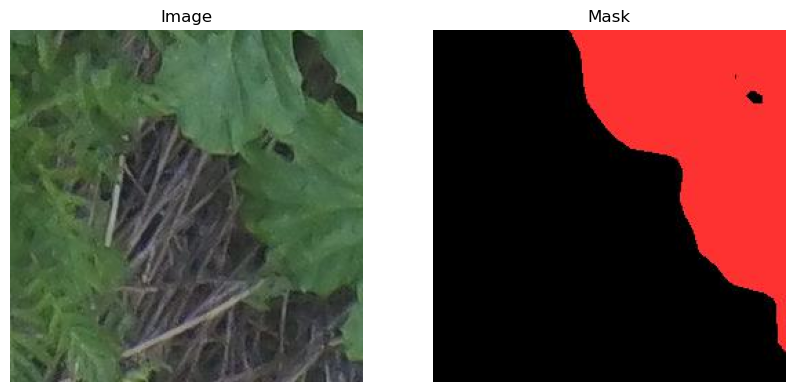

In [21]:
from PIL import Image

image_dir = 'self-labeled data/image_patches'
mask_dir = 'self-labeled data/mask_patches'
batch_size = 32

image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg')]
mask_files = [os.path.join(mask_dir, msk) for msk in os.listdir(mask_dir) if msk.endswith('.jpg')]

if image_files and mask_files:
    img_path = image_files[144]
    mask_path = mask_files[144]
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(mask)
    axes[1].set_title('Mask')
    axes[1].axis('off')
    
    plt.show()

**Split the data in training and test sets**

In [22]:
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

train_dataset = tfdata_generator(train_images, train_masks, batch_size)
test_dataset = tfdata_generator(test_images, test_masks, batch_size)

steps_per_epoch = len(train_images) // batch_size
validation_steps = len(test_images) // batch_size

for images, masks in test_dataset.take(1):
    test_images = images.numpy()
    test_masks = masks.numpy()

2024-06-10 15:25:08.762407: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-10 15:25:08.762430: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-06-10 15:25:08.762434: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-06-10 15:25:08.762462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 15:25:08.762480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 3: Exploratory Data Analysis </strong></h2>
</div>

**Percentage masks**

In [23]:
perc_mask_image = os.listdir(image_dir)
perc_mask = os.listdir(mask_dir)

num_images_with_masks = 0
num_images_without_masks = 0

for image_file in perc_mask_image:
    corresponding_mask_file = os.path.join(mask_dir, image_file)
    if image_file in perc_mask:
        mask = np.array(Image.open(corresponding_mask_file))
        if np.any(mask != 0):
            num_images_with_masks += 1
        else:
            num_images_without_masks += 1
    else:
        num_images_without_masks += 1

total_images = len(perc_mask_image)
percentage_with_masks = (num_images_with_masks / total_images) * 100
percentage_without_masks = (num_images_without_masks / total_images) * 100

print(f"Total number of images: {total_images}")
print(f"Percentage of images with masks: {round(percentage_with_masks, 1)}%")
print(f"Percentage of images without masks: {round(percentage_without_masks, 1)}%")

Total number of images: 8802
Percentage of images with masks: 22.6%
Percentage of images without masks: 77.4%


**Mask coverage**

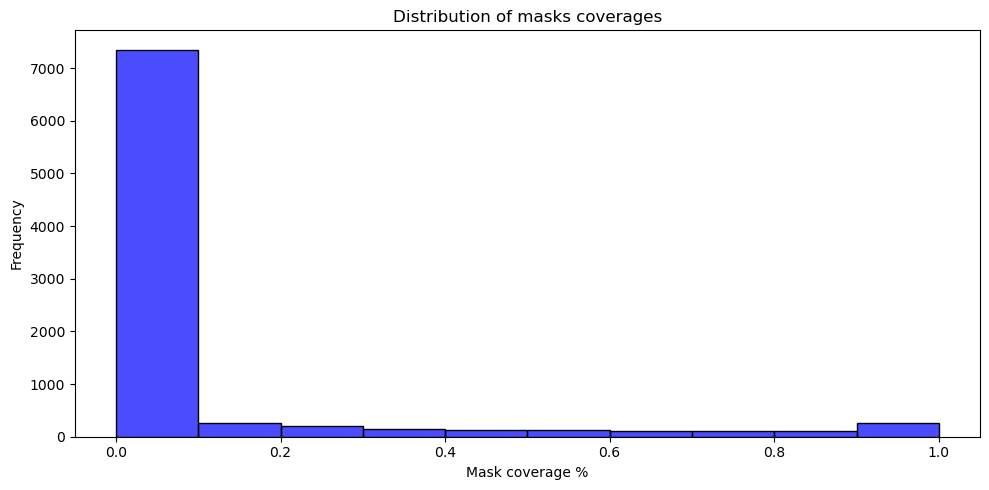

In [24]:
mask_coverages = []

for image_file in perc_mask_image:
    mask = Image.open(os.path.join(mask_dir, image_file)) 
    mask_array = np.array(mask)

    coverage = np.sum(mask_array > 0) / mask_array.size
    mask_coverages.append(coverage)
plt.figure(figsize=(10, 5))
sns.histplot(mask_coverages, kde=False, color='blue', alpha=0.7, bins=10) 
plt.title('Distribution of masks coverages')
plt.xlabel('Mask coverage %')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Inspecting a couple of images**

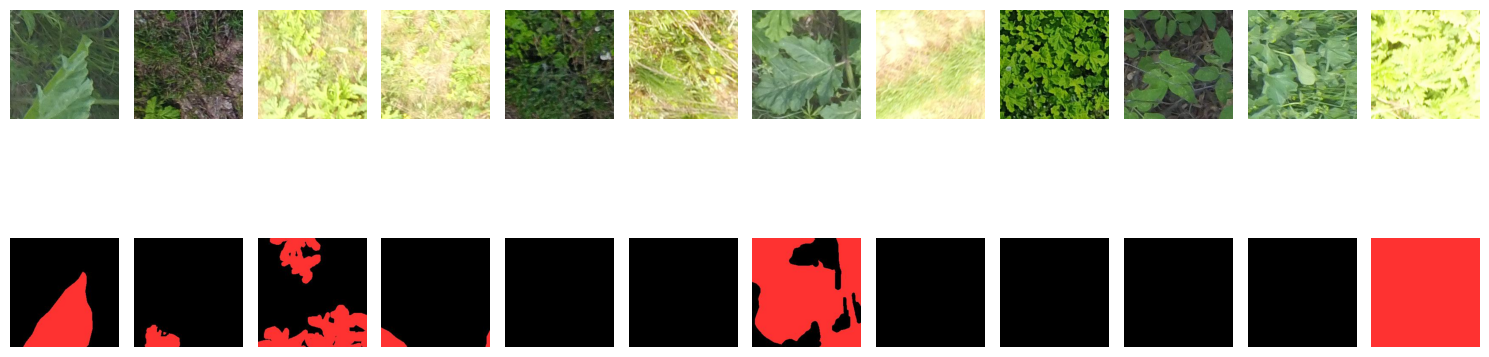

In [25]:
num_images_to_view = 12

plt.figure(figsize=(15, 6))
for i, image_file in enumerate(perc_mask_image[:num_images_to_view]):
    image = Image.open(os.path.join(image_dir, image_file))
    mask = Image.open(os.path.join(mask_dir, image_file))

    plt.subplot(2, num_images_to_view, i + 1)
    plt.imshow(image)
    plt.title('')
    plt.axis('off')

    plt.subplot(2, num_images_to_view, num_images_to_view + i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title('')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Resolutions**

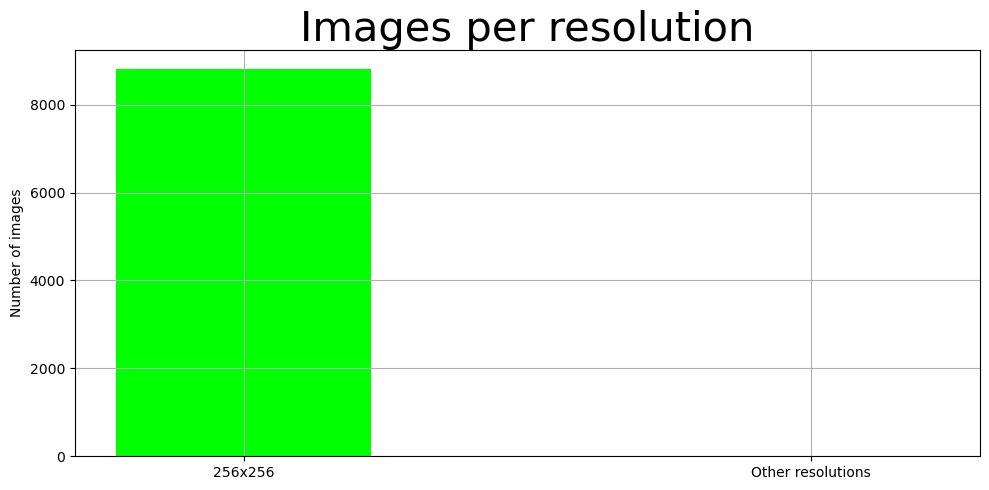

Most common resolution (256x256): 8802
Other resolutions: 0


In [26]:
widths = []
heights = []
resolutions = []

for image_file in perc_mask_image:
    image = Image.open(os.path.join(image_dir, image_file))
    width, height = image.size
    widths.append(width)
    heights.append(height)
    resolutions.append((width, height))

countings = Counter(resolutions)

common_res, common_count = countings.most_common(1)[0]

other_res_count = len(perc_mask_image) - common_count
plt.figure(figsize=(10, 5))
res_labels = [f'{common_res[0]}x{common_res[1]}', 'Other resolutions']
counts = [common_count, other_res_count]

plt.bar(res_labels, counts, color=['lime', 'orange'], alpha=1, width=0.45)
plt.title('Images per resolution', fontsize= 30)
plt.ylabel('Number of images')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Most common resolution ({common_res[0]}x{common_res[1]}): {common_count}")
print(f"Other resolutions: {other_res_count}")

**RGB channels**

In [25]:
red_channels = []
green_channels = []
blue_channels = []

for image_file in perc_mask_image:
    mask = Image.open(os.path.join(mask_dir, image_file))
    mask_array = np.array(mask)

    red_channels.append(mask_array[:, :, 0].flatten())
    green_channels.append(mask_array[:, :, 1].flatten())
    blue_channels.append(mask_array[:, :, 2].flatten())

mean_red = np.mean(red_channels, axis=0)
mean_green = np.mean(green_channels, axis=0)
mean_blue = np.mean(blue_channels, axis=0)

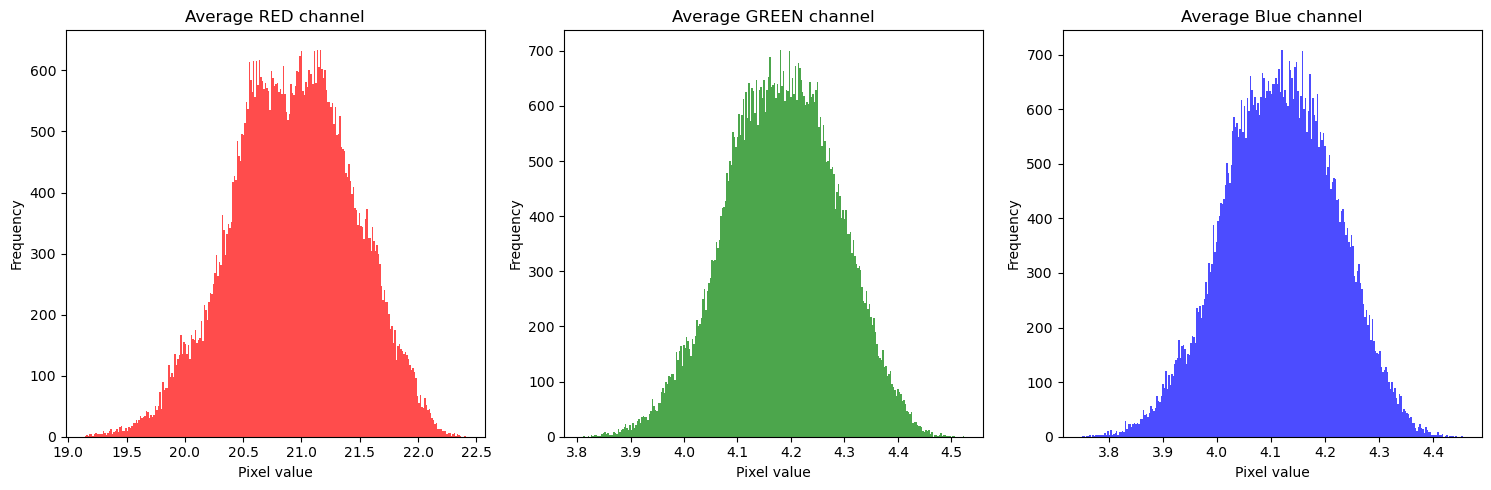

In [26]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.hist(mean_red, bins=256, color='red', alpha=0.7)
plt.title('Average RED channel')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')

plt.subplot(1, 4, 2)
plt.hist(mean_green, bins=256, color='green', alpha=0.7)
plt.title('Average GREEN channel')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')

plt.subplot(1, 4, 3)
plt.hist(mean_blue, bins=256, color='blue', alpha=0.7)
plt.title('Average Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Since we aim to detect giant hogweed, multiple factors are important such as the shape of the plant and its color. RGB values represent the color information of the image. For our problem, the color of the leaves and stems is very important. By examining the distribution, we can observe how the colors are spread. Additionally, color is important for distinguishing giant hogweed from other plants or the background.

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 4: Different Models </strong></h2>
</div>

### **Literature Review and Models**
For our task of detecting giant hogweed through pixel segmentation, it is important to use models that can segment accurately and in detail. Based on literature studies, we have made a good selection of deep learning models to achieve the best results for our task. These models are specifically designed for pixel segmentation tasks. Below, we have summarized what the papers consider to be the best models.

**Paper: "Comparison of Deep-Learning-Based Segmentation Models: Using Top View Person Images" by Imran Ahmed, Misbah Ahmad, Fakhri Alam Khan, and Muhammad Asif**

- U-Net:
    - Architecture: U-Net has an encoder-decoder structure with symmetric connections between the downsampling and upsampling paths, helping to retain detailed spatial information.
    - Performance: The model provides high accuracy in segmentation tasks by utilizing low- and high-resolution features.

- DeepLabV3:
    - Architecture: DeepLabV3 uses atrous convolutions to preserve high-resolution features without significantly increasing computational time. It uses ResNet-101 as a base and integrates parallel and consecutive modules of atrous convolutions.
    - Performance: DeepLabV3 outperforms many other models in terms of accuracy and preserving detailed objects. The model provides good results even in complex images and different lighting conditions.

- Fully Convolutional Network (FCN):
    - Architecture: FCN replaces fully connected layers with convolutional layers, allowing for dense pixel predictions. The model uses upsampling to generate output of the same size as the input.
    - Performance: FCN is often used as a baseline for other segmentation models due to its robust and good segmentation results. Although it may not always offer the highest accuracy, it is fast and effective for many applications.


**Paper: "Understanding Deep Learning Techniques for Image Segmentation" by Swarnendu Ghosh, Nibaran Das, Ishita Das, and Ujjwal Maulik**

- Deep Layer Cascade:
    - Why Good? This model operates in multiple stages where easily segmented areas are segmented immediately, and more difficult areas in later stages. This approach improves the speed and accuracy of segmentation.
    - Performance: Achieves an average Intersection over Union (IoU) of 82.7 on the VOC12 test set.

- DeepLab:
    - Why Good? DeepLab uses dilated convolutions, meaning the filter is expanded by skipping intermediate pixels during the operation (atrous), and fully connected conditional random fields (CRFs) to enhance contextual information without losing segmentation resolution, resulting in sharper segmentation output.
    - Performance: Achieves an average IoU of 79.7 on the PASCAL VOC 2012 dataset.

- PSPNet (Pyramid Scene Parsing Network):
    - Why Good? This model utilizes spatial pyramid pooling to leverage features at different scales, aiding in segmenting objects of different sizes in real environments.
    - Performance: Scores an average IoU of 57.21 on the ImageNet Scene Parsing Challenge.



**Paper: "A Review on Deep Learning Techniques Applied to Semantic Segmentation" by A. Garcia-Garcia, S. Orts-Escolano, S.O. Oprea, V. Villena-Martinez, and J. Garcia-Rodriguez**

- Fully Convolutional Networks (FCNs):
    - Description: FCNs have transformed traditional convolutional neural networks (CNNs) by replacing fully connected layers with convolutional layers that provide spatial maps instead of classification scores.
    - Reason for Success: This model can be trained end-to-end for semantic segmentation, enabling efficient and accurate predictions for each pixel. FCNs have demonstrated significant improvements in segmentation accuracy on datasets such as PASCAL VOC.

- DeepLab:
    - Description: DeepLab utilizes atrous convolutions, spatial pooling pyramids, and fully connected conditional random fields (CRFs).
    - Reason for Success: Atrous convolutions expand the field of view without increasing the number of parameters, helping to capture information without reducing segmentation sharpness. DeepLab achieved a high mean IoU of 79.7 on the PASCAL VOC 2012 dataset.

- DAG-RNN (Directed Acyclic Graph Recurrent Neural Network):
    - Description: This model uses a directed graph structure to model contextual information.
    - Reason for Success: DAG-RNN has achieved high accuracy on datasets such as CamVid (91.60 IoU) through context modeling.


### **Selected Models for Our Application**

Based on the mentioned papers and the specific requirements for detecting giant hogweed, we have selected the following models that we will use.

- U-Net:

    - Reason for choice: The encoder-decoder architecture of U-Net with skip connections ensures detailed segmentation while retaining spatial information. This is crucial for accurately identifying giant hogweed, as the model can effectively capture both high-level features and fine-grained details.

- DeepLab (DeepLabV3):

    - Reason for choice: The application of atrous convolutions (dilated convolutions) in DeepLabV3 allows for capturing multi-scale contextual information without losing resolution. Combined with conditional random fields, this results in sharp and precise segmentation outputs, which is particularly useful in complex images where giant hogweed may be intertwined with other vegetation.

- Fully Convolutional Network (FCN):

    - Reason for choice: FCNs offer a good balance between speed and accuracy, making them suitable for real-time applications. Their ability to process entire images quickly without fully connected layers makes them robust and efficient for detecting giant hogweed in various environments.

- Deep Layer Cascade:

    - Reason for choice: The Deep Layer Cascade model combines multiple deep networks to improve the accuracy and robustness of segmentation. By leveraging cascaded deep layers, the model can refine segmentation outputs progressively, making it particularly effective for challenging segmentation tasks like detecting giant hogweed amidst cluttered backgrounds.

- ResNet-50

    - Reason for choice: ResNet-50, with its deep residual learning framework, excels at capturing complex patterns and hierarchical features in images. Its robust architecture helps in maintaining high accuracy in segmentation tasks, making it suitable for distinguishing giant hogweed from other similar-looking plants. Additionally, its ability to prevent vanishing gradients allows for training deeper networks effectively.

    
With these models, we aim to achieve optimal performance in detecting and segmenting giant hogweed in images, enabling us to obtain accurate location information for further analysis.


### **U-Net**

##### Decoder & Encoder

In [45]:
def unet_model(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up1 = UpSampling2D((2, 2))(conv4)
    up1 = Conv2D(128, (2, 2), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    merge1 = Concatenate()([conv3, up1])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up2 = UpSampling2D((2, 2))(conv5)
    up2 = Conv2D(64, (2, 2), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    merge2 = Concatenate()([conv2, up2])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up3 = UpSampling2D((2, 2))(conv6)
    up3 = Conv2D(32, (2, 2), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    merge3 = Concatenate()([conv1, up3])
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(2, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    model = Model(inputs, outputs)
    return model

##### Compile the model

In [46]:
checkpoint_unet = create_model_checkpoint('unet')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model_unet = compile_model(unet_model())
model_unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 256, 256, 32)         896       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_32 (Ba  (None, 256, 256, 32)         128       ['conv2d_36[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_37 (Conv2D)          (None, 256, 256, 32)         9248      ['batch_normalization_32

##### Train the model

In [ ]:
history_unet = train_model(model_unet, 300, [checkpoint_unet, reduce_lr])

##### Model Evaluation

In [20]:
model_unet.save('fully_runned_model_unet.h5')

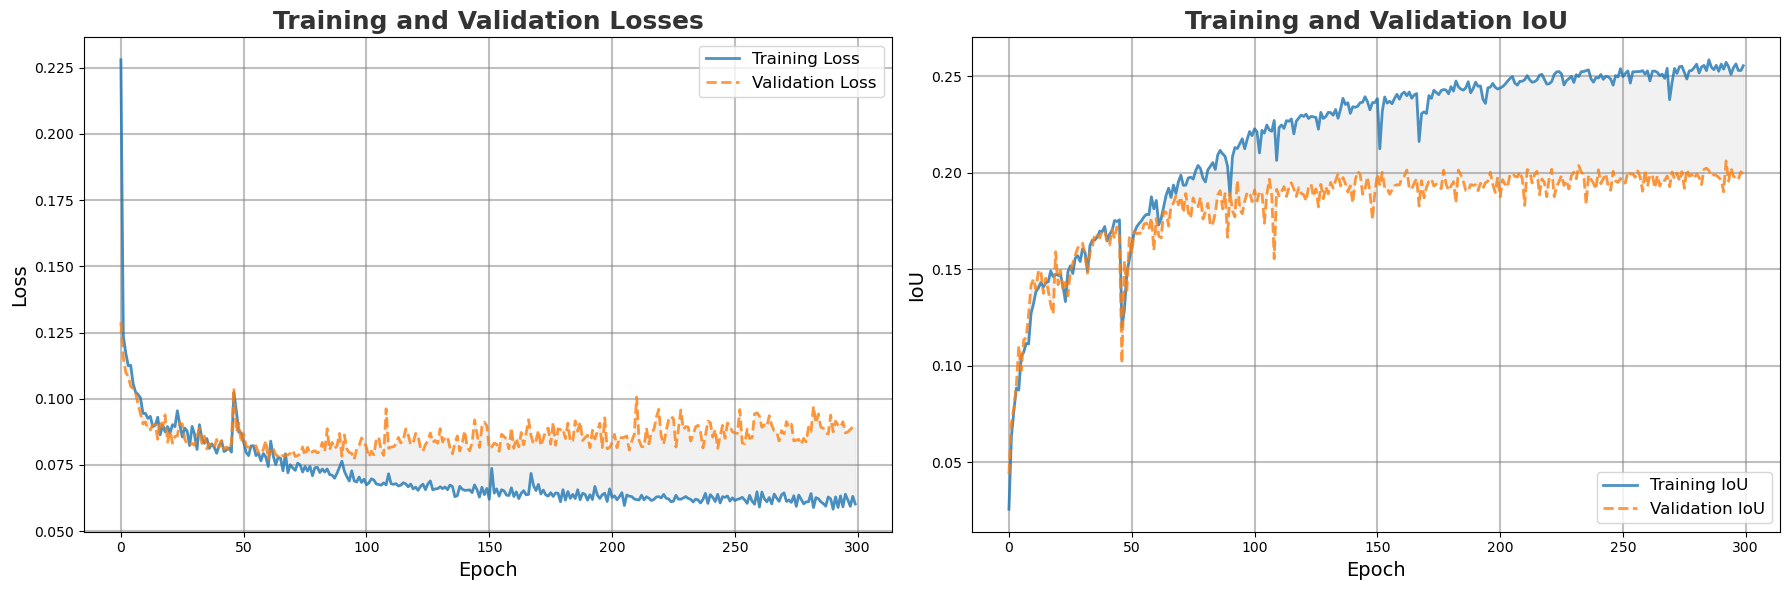

In [21]:
plot_loss(history_unet)

In [30]:
model_unet = load_model('/Users/vince/School - Datalab IV/Modellen/model_unet_300ep_best.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})

1/1 [==============================] - 0s 25ms/step


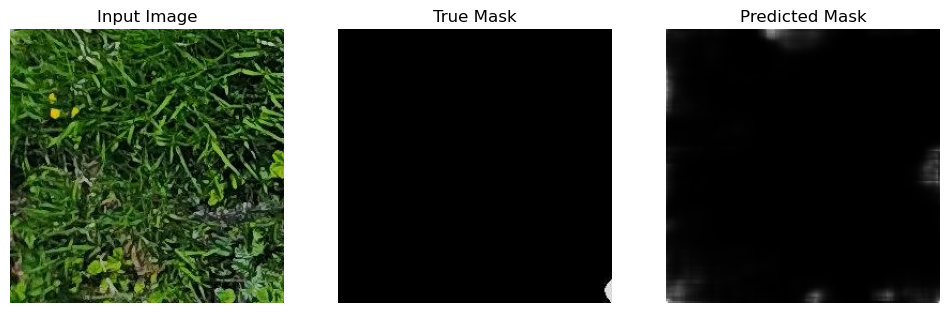

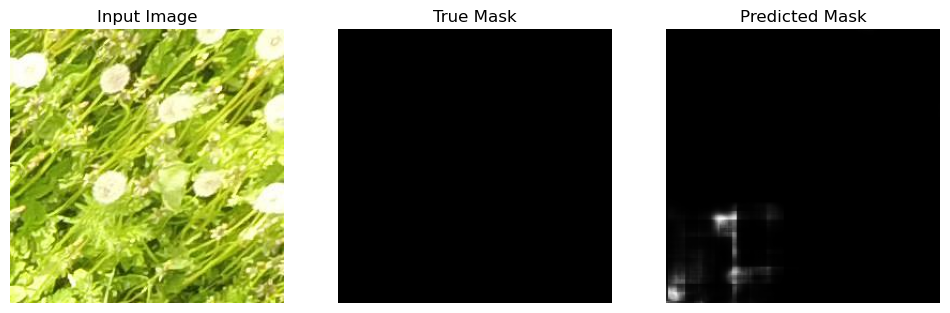

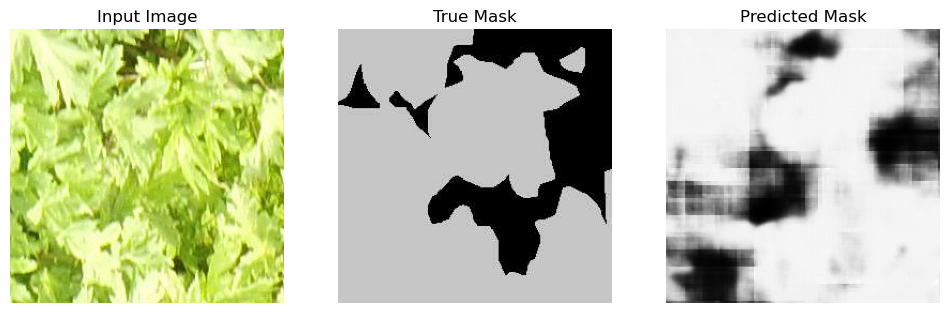

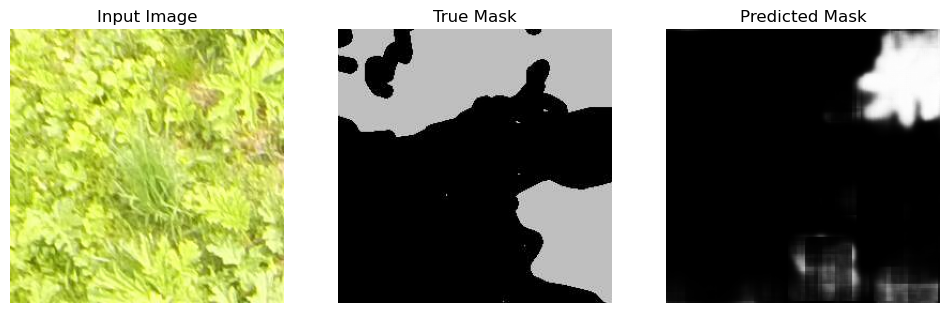

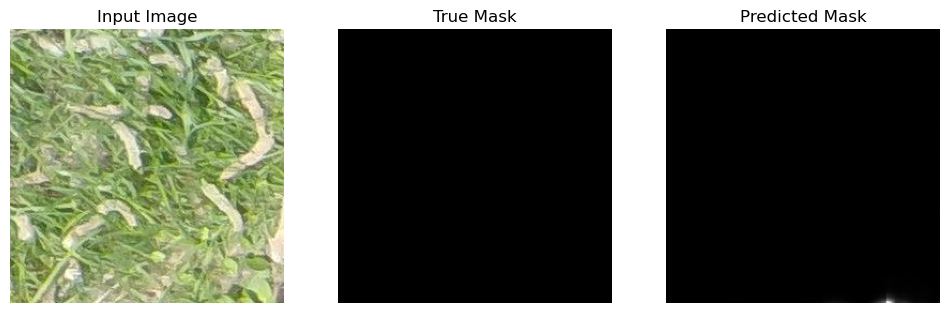

In [33]:
visualize_results(model_unet, test_images[20:25], test_masks[20:25])

### **DeepLab**

##### Define the model

In [37]:
def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):  
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    image_features = base_model.get_layer('relu').output

    b0 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(image_features)
    b0 = layers.BatchNormalization()(b0)
    b1 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', dilation_rate=6)(image_features)
    b1 = layers.BatchNormalization()(b1)
    b2 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', dilation_rate=12)(image_features)
    b2 = layers.BatchNormalization()(b2)
    b3 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', dilation_rate=18)(image_features)
    b3 = layers.BatchNormalization()(b3)
    b4 = layers.GlobalAveragePooling2D()(image_features)
    b4 = layers.Reshape((1, 1, b4.shape[-1]))(b4)
    b4 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(b4)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.UpSampling2D(size=(image_features.shape[1], image_features.shape[2]), interpolation='bilinear')(b4)
    
    x = layers.Concatenate()([b0, b1, b2, b3, b4])
    x = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.UpSampling2D((4, 4), interpolation='bilinear')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(x)
    x = layers.UpSampling2D((8, 8), interpolation='bilinear')(x) 
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

##### Compile the model

In [38]:
model_deeplab = compile_model(DeeplabV3Plus())
checkpoint_deeplab = create_model_checkpoint('deeplab')

model_deeplab.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 262, 262, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_6[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']    

##### Train the model

In [ ]:
history_deeplab = train_model(model_deeplab, 80, [checkpoint_deeplab, reduce_lr])

##### Model evaluation

In [ ]:
plot_loss(history_deeplab)

In [40]:
model_deeplab = load_model('models/model_deeplab.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})

1/1 [==============================] - 0s 145ms/step


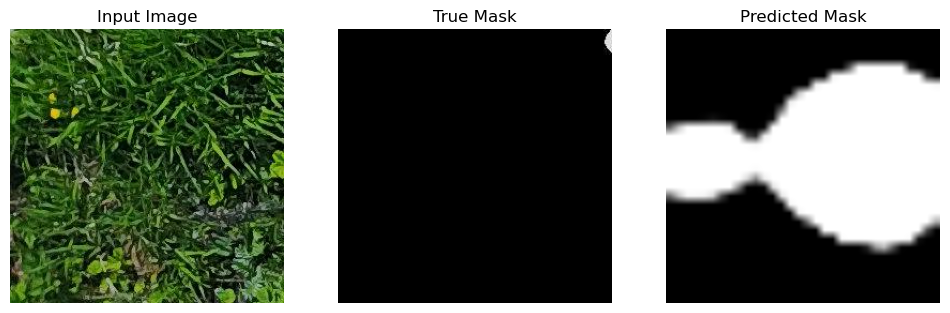

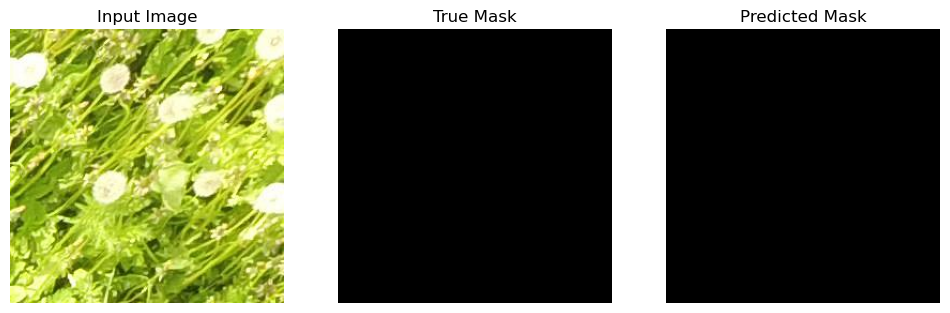

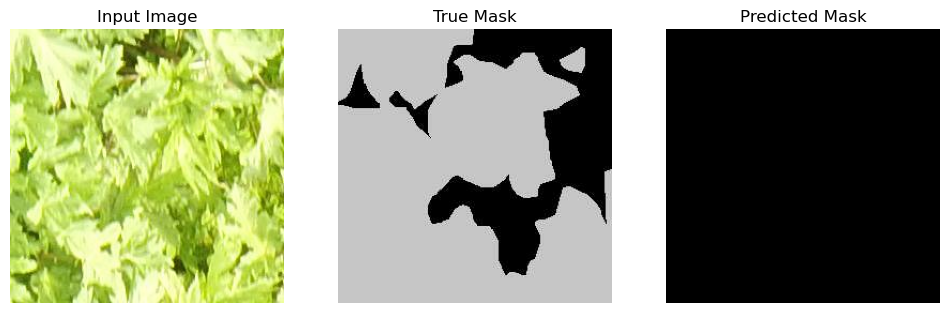

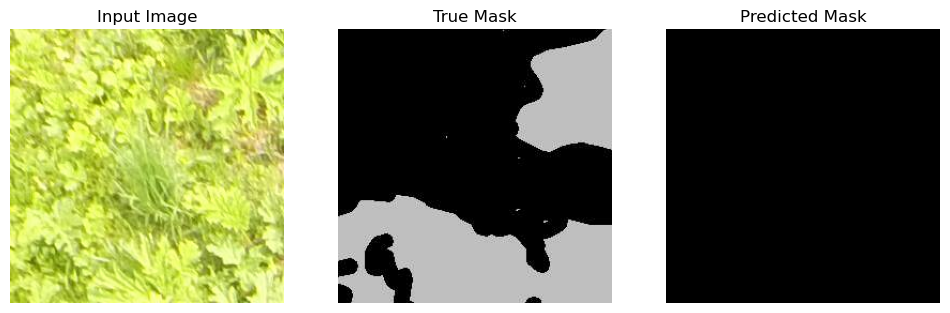

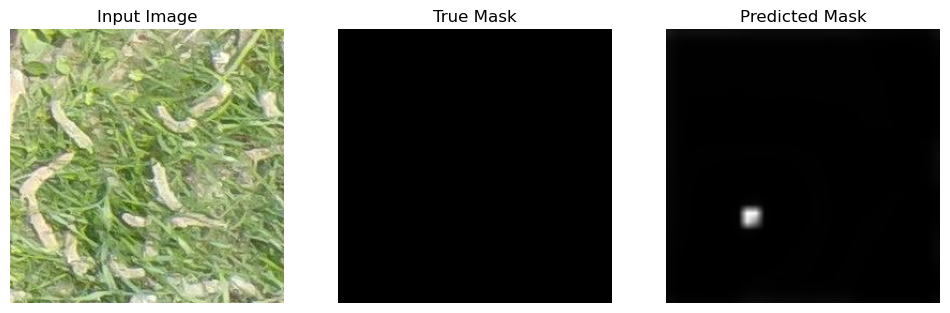

In [44]:
visualize_results(model_deeplab, test_images[20:25], test_masks[20:25])

### **Fully Convolutional Network (FCN)**

##### Define the model

In [21]:
def fcn_model(input_shape = (256, 256, 3)):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    up1 = UpSampling2D((2, 2))(pool3)
    up1 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Concatenate()([up1, conv3])
    
    up2 = UpSampling2D((2, 2))(up1)
    up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Concatenate()([up2, conv2])
    
    up3 = UpSampling2D((2, 2))(up2)
    up3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Concatenate()([up3, conv1])
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(up3)
    
    model = Model(inputs, outputs)
    return model

##### Compile the model

In [22]:
model_fcn = compile_model(fcn_model())
checkpoint_fcn = create_model_checkpoint('fcn')

model_fcn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['batch_normalization[0][0

##### Train the model

In [23]:
history_fcn = train_model(model_fcn, 80, [checkpoint_fcn])

Epoch 1/80


2024-06-09 13:40:43.325203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - ETA: 0s - loss: 0.7709 - iou: 0.1333

2024-06-09 13:51:47.713435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_iou improved from -inf to 0.00168, saving model to ./models/model_fcn.h5
220/220 [==============================] - 699s 3s/step - loss: 0.7709 - iou: 0.1333 - val_loss: 0.9966 - val_iou: 0.0017
Epoch 2/80


/Users/vince/tensorflow-env/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - ETA: 0s - loss: 0.7226 - iou: 0.1648
Epoch 2: val_iou did not improve from 0.00168
220/220 [==============================] - 697s 3s/step - loss: 0.7226 - iou: 0.1648 - val_loss: 0.9997 - val_iou: 1.6140e-04
Epoch 3/80
220/220 [==============================] - ETA: 0s - loss: 0.7065 - iou: 0.1749
Epoch 3: val_iou improved from 0.00168 to 0.13196, saving model to ./models/model_fcn.h5
220/220 [==============================] - 691s 3s/step - loss: 0.7065 - iou: 0.1749 - val_loss: 0.7707 - val_iou: 0.1320
Epoch 4/80
220/220 [==============================] - ETA: 0s - loss: 0.6952 - iou: 0.1832
Epoch 4: val_iou improved from 0.13196 to 0.14822, saving model to ./models/model_fcn.h5
220/220 [==============================] - 691s 3s/step - loss: 0.6952 - iou: 0.1832 - val_loss: 0.7449 - val_iou: 0.1482
Epoch 5/80
220/220 [==============================] - ETA: 0s - loss: 0.6942 - iou: 0.1846
Epoch 5: val_iou improved from 0.14822 to 0.15834, sa

In [ ]:
model_fcn.save('model_fcn_fullrun_80ep.h5')

##### Model evaluation

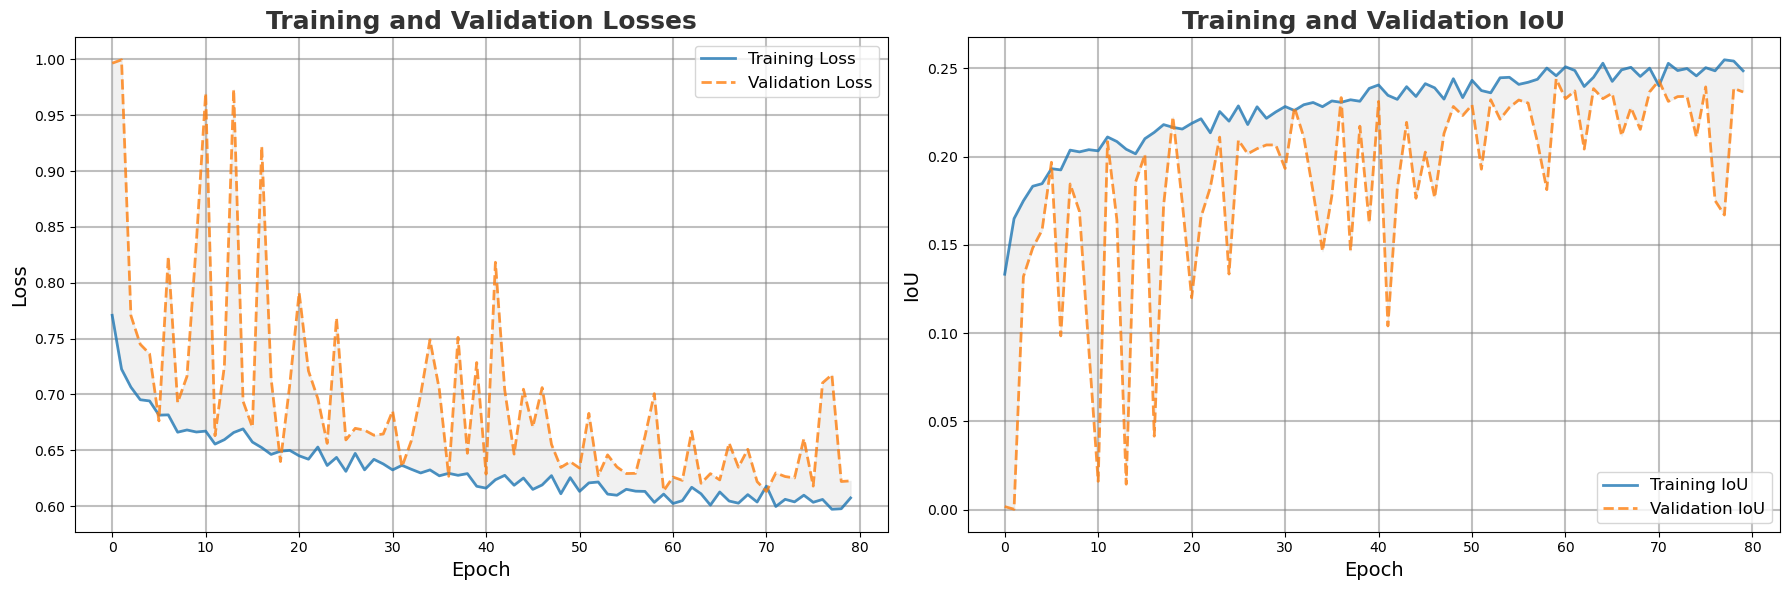

In [24]:
plot_loss(history_fcn)

In [23]:
model_fcn = load_model('models/model_fcn_best_80ep.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})

1/1 [==============================] - 0s 114ms/step


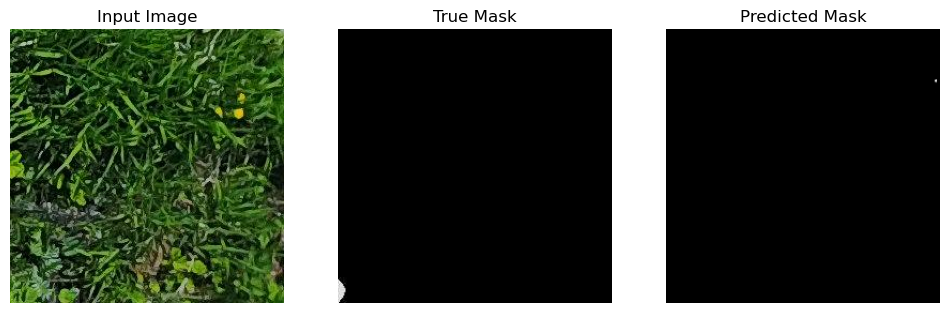

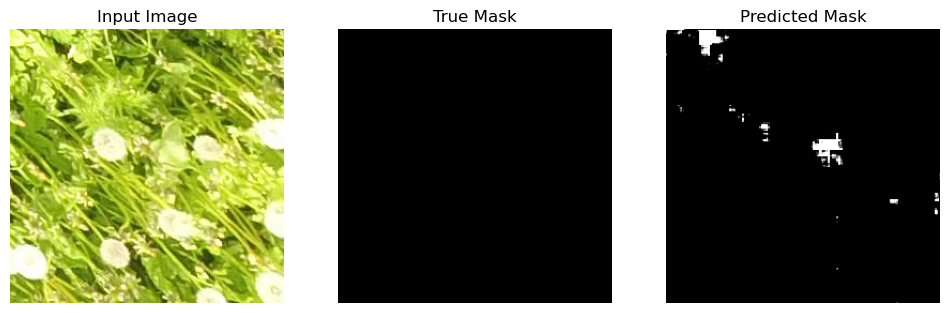

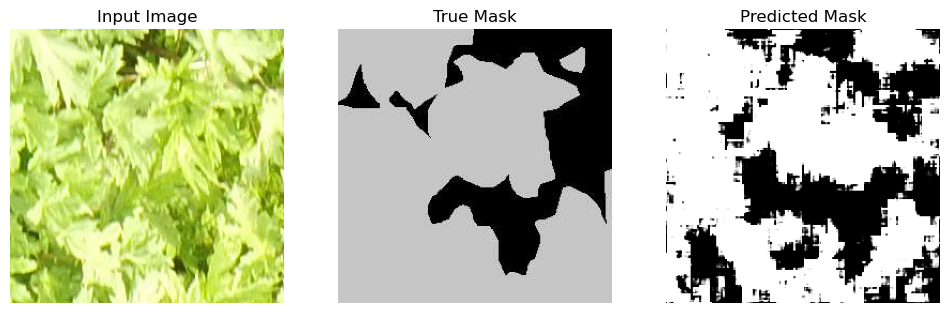

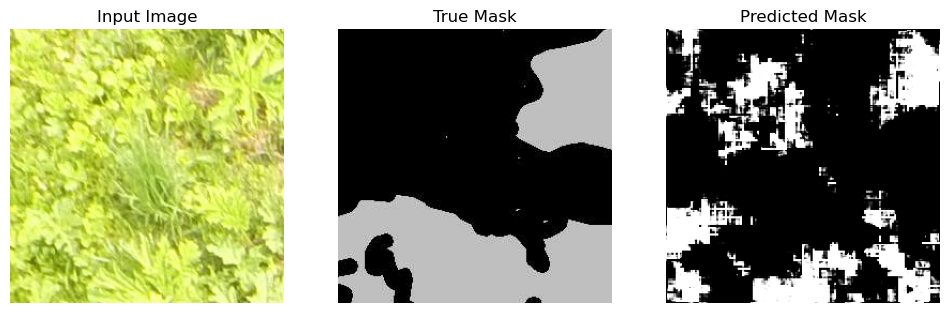

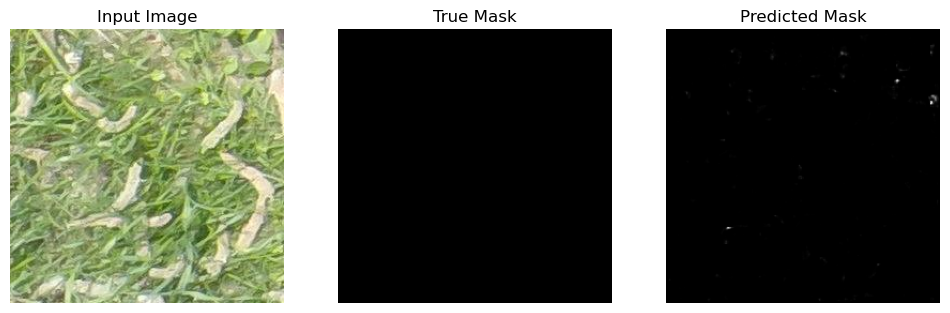

In [32]:
visualize_results(model_fcn, test_images[20:25], test_masks[20:25])

### **Deep Layer Cascade**

##### Define the model

In [18]:
def c_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    return x

def small_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    c1 = c_block(inputs, 32)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = c_block(p1, 64)
    p2 = MaxPooling2D((2, 2))(c2)
    bn = c_block(p2, 128)

    u1 = UpSampling2D((2, 2))(bn)
    concat1 = concatenate([u1, c2])
    c3 = c_block(concat1, 64)

    u2 = UpSampling2D((2, 2))(c3)
    concat2 = concatenate([u2, c1])
    c4 = c_block(concat2, 32)

    outputs = Conv2D(1, 1, activation='sigmoid')(c4)
    return Model(inputs, outputs)

def deep_layer_cascade(input_size=(256, 256, 3), num_layers=3):
    inputs = Input(input_size)
    x = inputs
    for _ in range(num_layers - 1):
        x = c_block(x, 3)
    x = small_unet(input_size)(x)
    return Model(inputs, x)

##### Compile the model

In [19]:
model_deeplayer = compile_model(deep_layer_cascade())
checkpoint_deeplayer = create_model_checkpoint('deeplayer')

model_deeplayer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 3)       84        
                                                                 
 batch_normalization (Batch  (None, 256, 256, 3)       12        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 3)       84        
                                                                 
 batch_normalization_1 (Bat  (None, 256, 256, 3)       12        
 chNormalization)                                          

##### Train the model

In [20]:
history_dlc = train_model(model_deeplayer, 300, [checkpoint_deeplayer])

Epoch 1/300


2024-06-06 14:19:53.522993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - ETA: 0s - loss: 0.8262 - iou: 0.0967

2024-06-06 14:25:21.225095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_iou improved from -inf to 0.03522, saving model to ./models/model_deeplayer.h5
110/110 [==============================] - 342s 3s/step - loss: 0.8262 - iou: 0.0967 - val_loss: 0.9323 - val_iou: 0.0352
Epoch 2/300


/Users/vince/tensorflow-env/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - ETA: 0s - loss: 0.7093 - iou: 0.1707
Epoch 2: val_iou did not improve from 0.03522
110/110 [==============================] - 329s 3s/step - loss: 0.7093 - iou: 0.1707 - val_loss: 0.9328 - val_iou: 0.0349
Epoch 3/300
110/110 [==============================] - ETA: 0s - loss: 0.6609 - iou: 0.2042
Epoch 3: val_iou improved from 0.03522 to 0.06440, saving model to ./models/model_deeplayer.h5
110/110 [==============================] - 318s 3s/step - loss: 0.6609 - iou: 0.2042 - val_loss: 0.8797 - val_iou: 0.0644
Epoch 4/300
110/110 [==============================] - ETA: 0s - loss: 0.6494 - iou: 0.2127
Epoch 4: val_iou improved from 0.06440 to 0.08628, saving model to ./models/model_deeplayer.h5
110/110 [==============================] - 340s 3s/step - loss: 0.6494 - iou: 0.2127 - val_loss: 0.8421 - val_iou: 0.0863
Epoch 5/300
110/110 [==============================] - ETA: 0s - loss: 0.6384 - iou: 0.2213
Epoch 5: val_iou improved from 0.08628 to 

##### Model evaluation

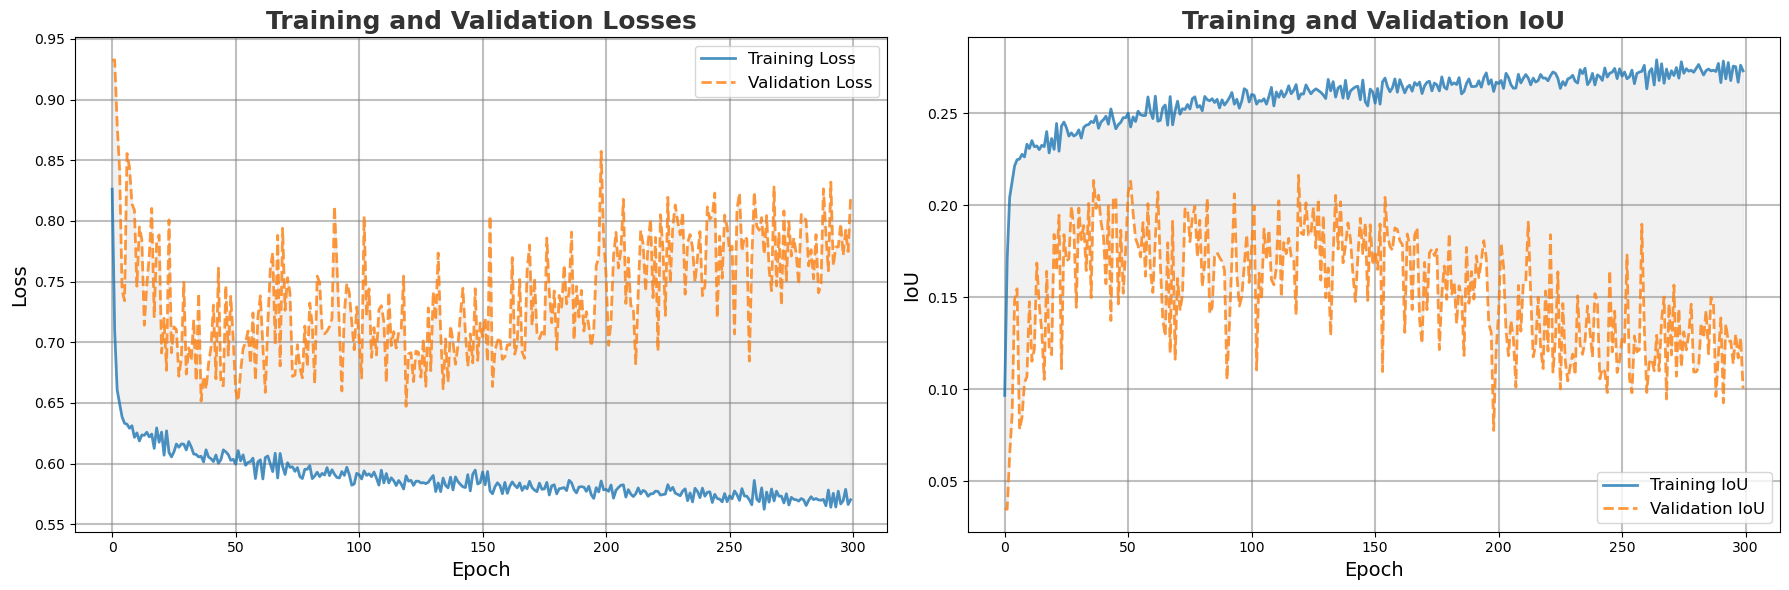

In [21]:
plot_loss(history_dlc)

In [33]:
model_deeplayer = load_model('models/model_deeplayer.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})

1/1 [==============================] - 0s 54ms/step


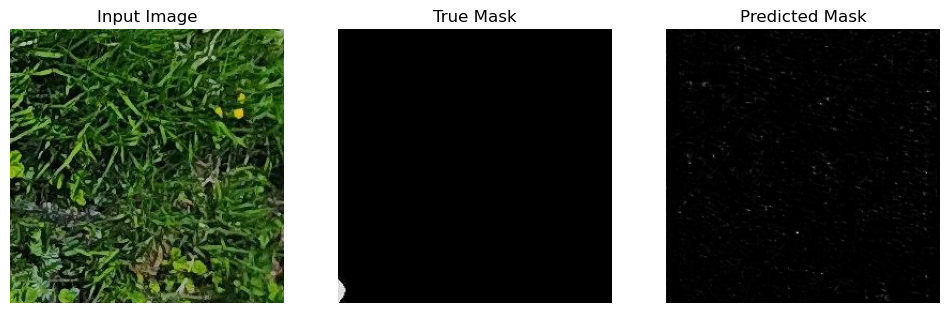

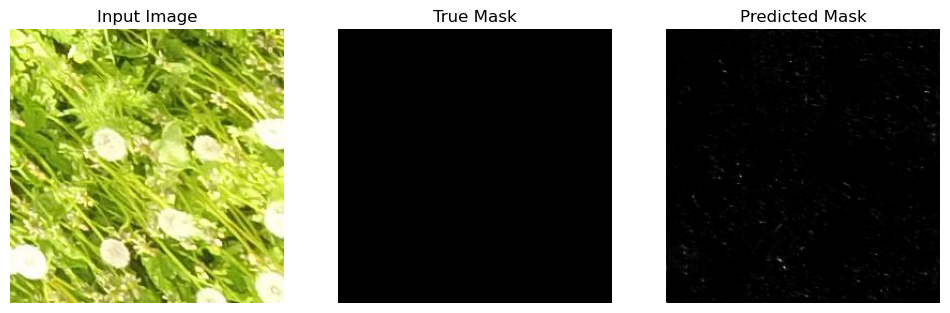

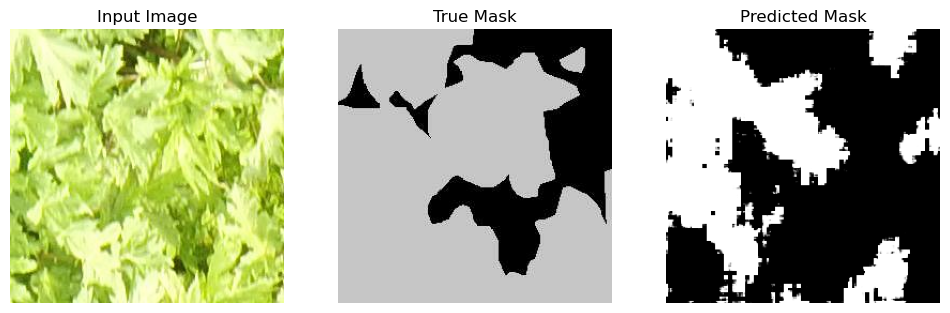

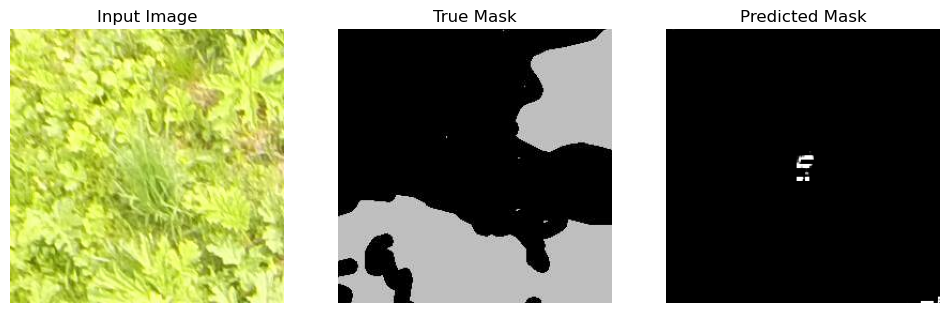

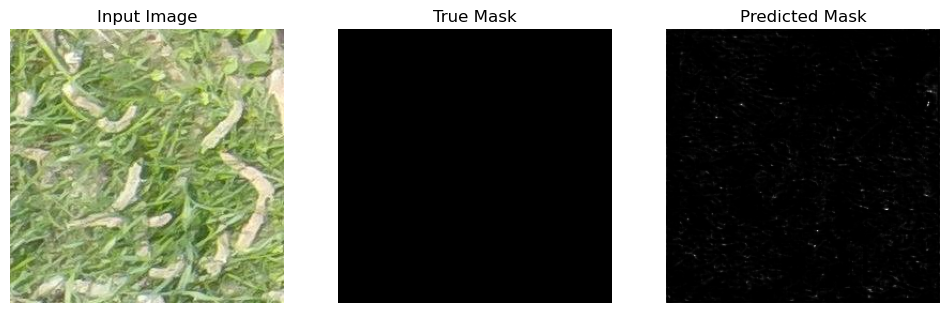

In [35]:
visualize_results(model_deeplayer, test_images[20:25], test_masks[20:25])

### **ResNet-50**

##### Define the model

In [19]:
def ResNet50_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    layer_names = [
        'conv1_relu',  
        'conv2_block3_out',  
        'conv3_block4_out',  
        'conv4_block6_out', 
        'conv5_block3_out'  
    ]
    layers = [resnet.get_layer(name).output for name in layer_names]

    def upsample_concat(x, skip, filters):
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = concatenate([x, skip])
        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        return x

    x = layers[-1]
    x = upsample_concat(x, layers[-2], 512)
    x = upsample_concat(x, layers[-3], 256)
    x = upsample_concat(x, layers[-4], 128)
    x = upsample_concat(x, layers[-5], 64)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    model = Model(inputs, outputs)

    return model

model_resnet = ResNet50_model()

#### Compile the model

In [20]:
model_resnet = compile_model(ResNet50_model())
checkpoint_resnet = create_model_checkpoint('resnet')

model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

##### Train the model

In [23]:
history_resnet = train_model(model_resnet, 300, [checkpoint_resnet])

Epoch 1/15


2024-06-06 11:24:36.972444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - ETA: 0s - loss: 0.9305 - iou: 0.0361

2024-06-06 11:34:47.988247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_iou did not improve from 0.03517
110/110 [==============================] - 636s 6s/step - loss: 0.9305 - iou: 0.0361 - val_loss: 0.9324 - val_iou: 0.0351
Epoch 2/15
110/110 [==============================] - ETA: 0s - loss: 0.9303 - iou: 0.0359
Epoch 2: val_iou did not improve from 0.03517
110/110 [==============================] - 635s 6s/step - loss: 0.9303 - iou: 0.0359 - val_loss: 0.9331 - val_iou: 0.0347
Epoch 3/15
110/110 [==============================] - ETA: 0s - loss: 0.9314 - iou: 0.0353
Epoch 3: val_iou did not improve from 0.03517
110/110 [==============================] - 592s 5s/step - loss: 0.9314 - iou: 0.0353 - val_loss: 0.9322 - val_iou: 0.0352
Epoch 4/15
110/110 [==============================] - ETA: 0s - loss: 0.9299 - iou: 0.0361
Epoch 4: val_iou improved from 0.03517 to 0.03541, saving model to ./models/model_resnet.h5


/Users/vince/tensorflow-env/tensorflow/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 571s 5s/step - loss: 0.9299 - iou: 0.0361 - val_loss: 0.9318 - val_iou: 0.0354
Epoch 5/15
110/110 [==============================] - ETA: 0s - loss: 0.9306 - iou: 0.0357
Epoch 5: val_iou did not improve from 0.03541
110/110 [==============================] - 581s 5s/step - loss: 0.9306 - iou: 0.0357 - val_loss: 0.9321 - val_iou: 0.0352
Epoch 6/15
110/110 [==============================] - ETA: 0s - loss: 0.9299 - iou: 0.0361
Epoch 6: val_iou did not improve from 0.03541
110/110 [==============================] - 635s 6s/step - loss: 0.9299 - iou: 0.0361 - val_loss: 0.9334 - val_iou: 0.0346
Epoch 7/15
110/110 [==============================] - ETA: 0s - loss: 0.9313 - iou: 0.0354
Epoch 7: val_iou improved from 0.03541 to 0.03555, saving model to ./models/model_resnet.h5
110/110 [==============================] - 565s 5s/step - loss: 0.9313 - iou: 0.0354 - val_loss: 0.9315 - val_iou: 0.0356
Epoch 8/15
110/110 [==============================] - E

#### Model evaluation

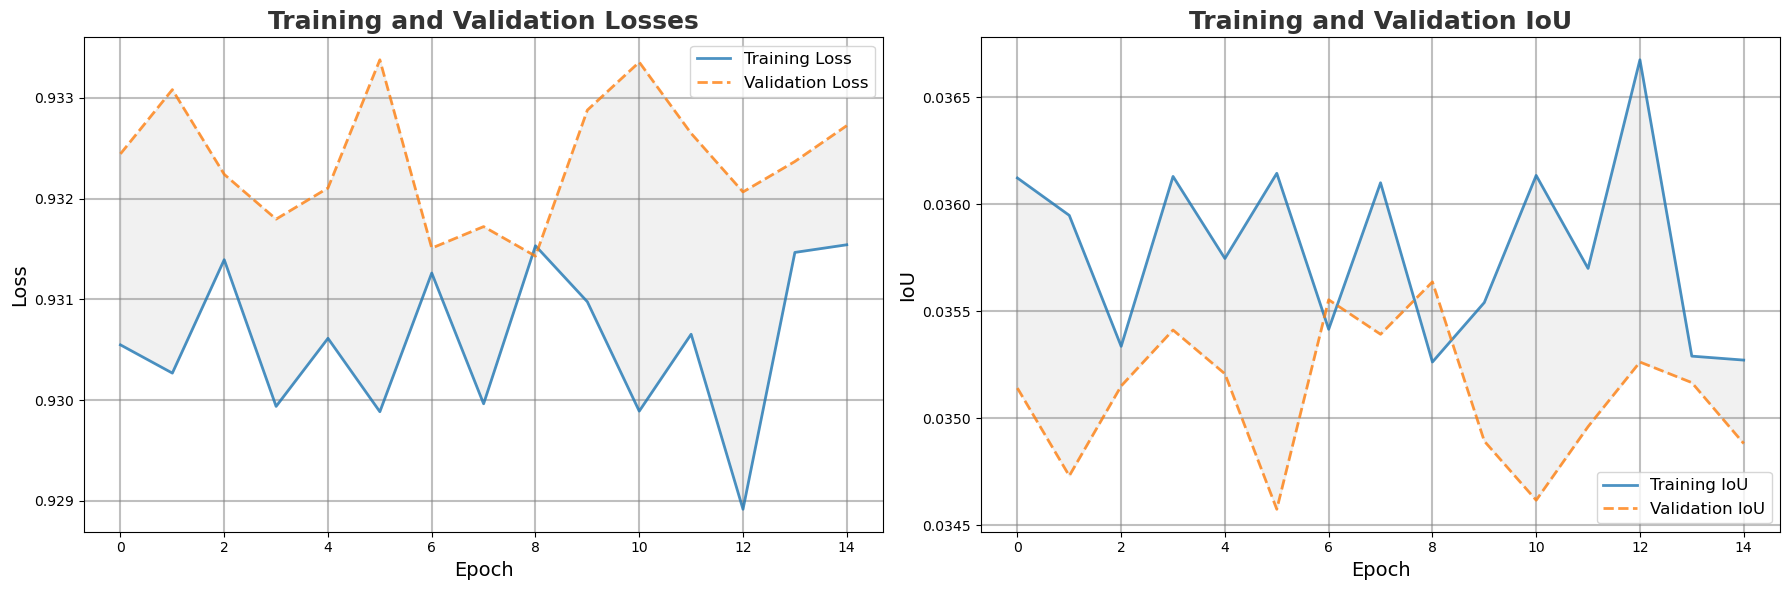

In [24]:
plot_loss(history_resnet)

In [ ]:
model_resnet = load_model('/Users/vince/School - Datalab IV/Modellen/model_resnet.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})

In [ ]:
visualize_results(model_resnet, test_images[:5], test_masks[:5])

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 5: Comparing the Models </strong></h2>
</div>

##### Collecting the best IoU scores

In [62]:
iou_unet = 0.20621
iou_deeplab = 0.1452
iou_fcn = 0.15081
iou_dlc = 0.1190
iou_resnet = 0.0943

iou_scores = {
    'U-Net': iou_unet,
    'Deeplab': iou_deeplab,
    'Fully Convolutional Network': iou_fcn,
    'Deep Layer Cascade': iou_dlc,
    'ResNet-50': iou_resnet
}

##### Visualize the different models

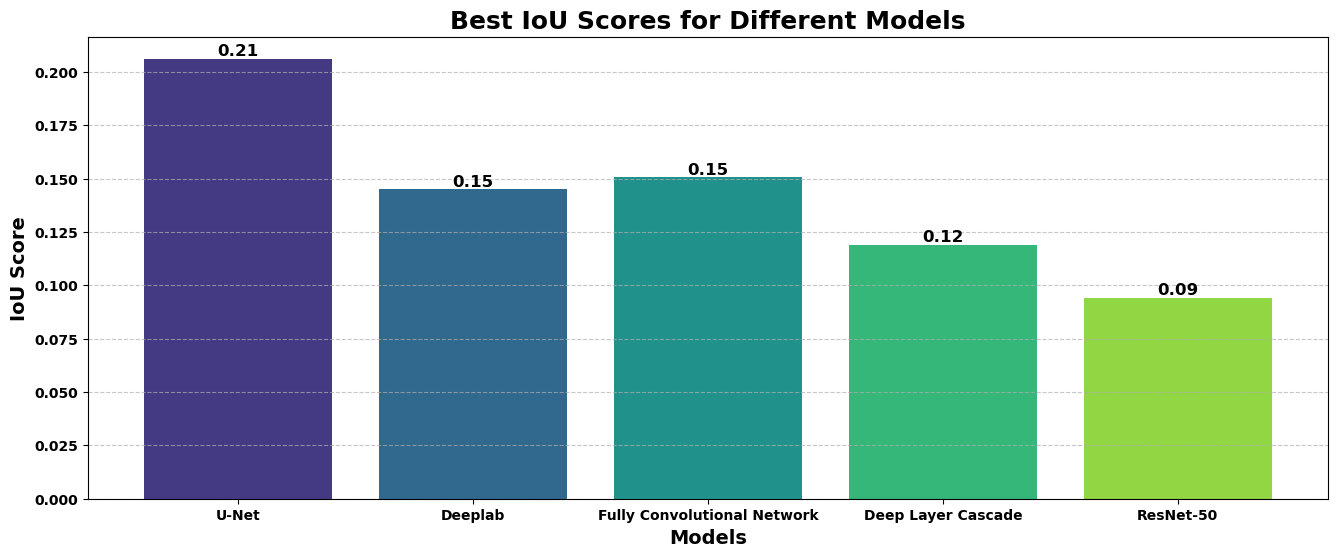

In [66]:
colors = sns.color_palette("viridis", len(iou_scores))

plt.figure(figsize=(16, 6))
bars = plt.bar(iou_scores.keys(), iou_scores.values(), color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Best IoU Scores for Different Models', fontsize=18, fontweight='bold')
plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('IoU Score', fontsize=14, fontweight='bold')

plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

##### Loading the different models

In [53]:
model_unet = load_model('/Users/vince/School - Datalab IV/Modellen/model_unet_300ep_best.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})
model_deeplab = load_model('models/model_deeplab.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})
model_fcn = load_model('models/model_fcn_best_80ep.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})
model_deeplayer = load_model('models/model_deeplayer.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})
model_resnet = load_model('/Users/vince/School - Datalab IV/Modellen/model_resnet_best_15ep.h5', custom_objects={'iou': iou, 'dice_loss': dice_loss})

##### The different predictions

1/1 [==============================] - 0s 30ms/step


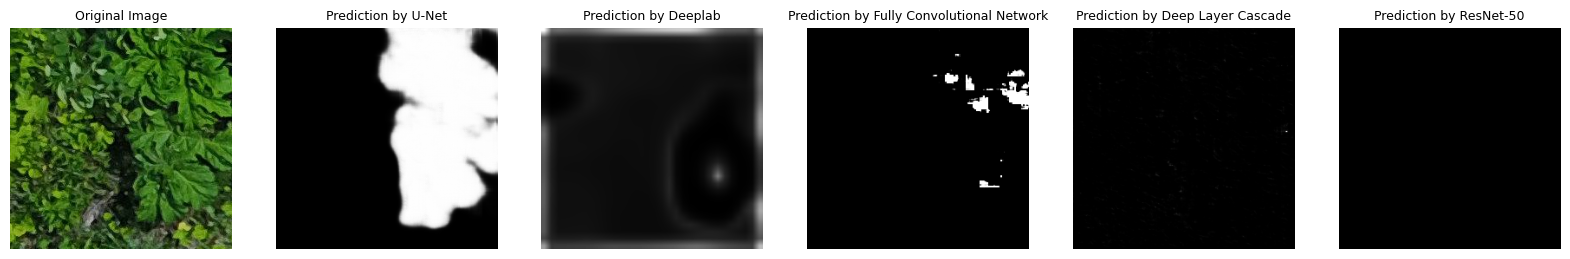

In [58]:
test_image_path = 'self-labeled data/image_patches/0099_patch_3_1.jpg' 
models = [model_unet, model_deeplab, model_fcn, model_deeplayer, model_resnet]
model_names = ['U-Net', 'Deeplab', 'Fully Convolutional Network', 'Deep Layer Cascade', 'ResNet-50']

plot_predictions(test_image_path, models, model_names)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 6: Using own data on the best model </strong></h2>
</div>

1/1 [==============================] - 1s 511ms/step


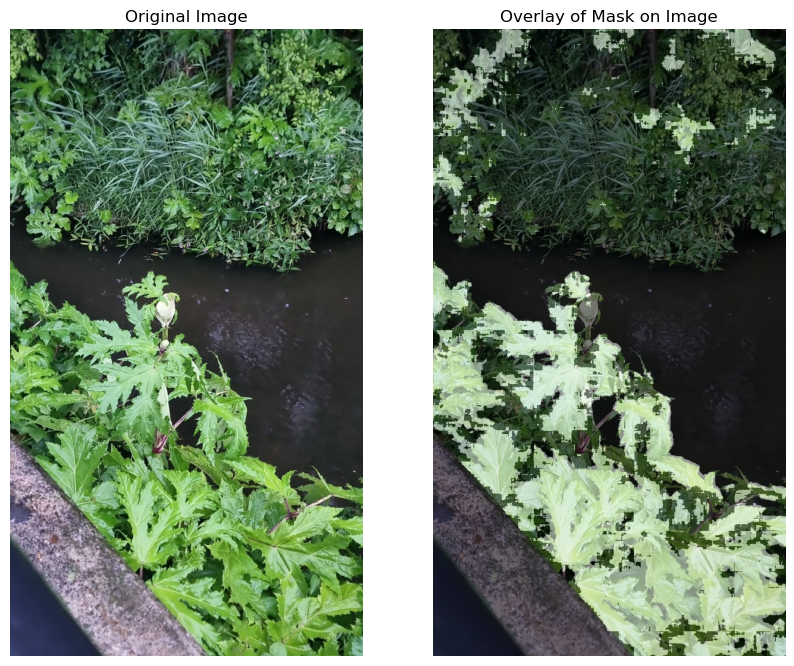

In [30]:
own_image_path = 'Eigen data/test.jpeg'
own_image = load_single_image(own_image_path, target_size=None)  

own_image = np.expand_dims(own_image, axis=-1) if own_image.shape[-1] == 1 else own_image
patches = split_image(own_image, patch_size=256)

patches_array = np.array(patches)
pred_patches = model_fcn.predict(patches_array)
pred_patches_thresholded = threshold_predictions(pred_patches, threshold=0.9)

pred_patches_thresholded = [np.squeeze(patch, axis=-1) if patch.shape[-1] == 1 else patch for patch in pred_patches_thresholded]
reconstructed_mask = merge_patches(pred_patches_thresholded, own_image.shape, patch_size=256)

display_prediction_images(own_image, reconstructed_mask)

- activation

    - unit step
    - sign (signum)
    - hard sigmoid

- loss

    - iou loss keras en tf



---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 7: API to call the best model </strong></h2>
</div>

When the file ‘fast_api.py’ is running, you can execute this code to invoke the model on your own image.

In [ ]:
url = "http://0.0.0.0:8000/predict/"

image_path = "eigen data/20240408_133818.jpg"

with open(image_path, "rb") as f:
    files = {"file": f}
    response = requests.post(url, files=files)

if response.status_code == 200:
    result = response.json()
    original_image = bytes.fromhex(result['original_image'])
    prediction_image = bytes.fromhex(result['prediction_image'])
    overlay_image = bytes.fromhex(result['overlay_image'])

    display(Image(data=original_image))
    display(Image(data=prediction_image))
    display(Image(data=overlay_image))
else:
    print(f"Error: {response.status_code}")
    print(response.text)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 8: Results and Conclusions </strong></h2>
</div>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 9: Sources </strong></h2>
</div>

- _GeeksforGeeks. (2022, 1 augustus). Image segmentation using TensorFlow. GeeksforGeeks._ https://www.geeksforgeeks.org/image-segmentation-using-tensorflow/

- _DLopatkin. (z.d.). GitHub - DLopatkin/Heracleum-Dataset: Dataset of aerial images of hogweed gathered in Moscow Region. GitHub._ https://github.com/DLopatkin/Heracleum-Dataset/tree/master

- _ChatGPT, 2024. Prompt 1:voorbeeld code van een deep layer cascade model._ https://chatgpt.com/share/1566f522-9075-45eb-b347-3c03f90989e3

- _Team, K. (n.d.). Keras documentation: Multiclass semantic segmentation using DeepLabV3+._ https://keras.io/examples/vision/deeplabv3_plus/